In [1]:
# Import packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

## Colour analysis

In [2]:
# Load train and test sets from pickle
with open('train_imgs.pkl', 'rb') as f:
    train_imgs = pickle.load(f)
with open('test_imgs.pkl', 'rb') as f:
    test_imgs = pickle.load(f)

In [3]:
def process_img(img, uppermask, lowermask):
    ''' Function to count the red pixels of an image in HSV'''

    opencv = np.array(img)[:, :, ::-1].copy() # Pass image to OpenCV framework
    hsv = cv2.cvtColor(opencv, cv2.COLOR_BGR2HSV) # Pass image to HSV colour space
    mask = cv2.inRange(hsv, uppermask, lowermask) # Create mask for red colour
    
    # Apply the mask to the image
    output_hsv = hsv.copy()
    output_hsv[np.where(mask==0)] = 0     
    return np.sum(output_hsv) 

In [4]:
# Append the red pixels count of each image
masking = [np.array([160,25,100]), np.array([179,255,255])] # Mask for detecting red colour in HSV

# Creating features for validation set
for image in train_imgs:
    npixels = process_img(image['img'][0], masking[0], masking[1]) # Number of red pixels
    if len(image['img']) > 1:
        recpixels = process_img(image['img'][1], masking[0], masking[1]) 
        image['info'].append(npixels)   
        image['info'].append(abs(npixels - recpixels)) # Absolute difference between original and reconstructed image        
        image['info'].append(round((recpixels+1)/(npixels+1), 4)) # Percentage difference. Add 1 to avoid division by 0

# Creating features for test set
for image in test_imgs:
    npixels = process_img(image['img'][0], masking[0], masking[1]) # Number of red pixels
    recpixels = process_img(image['img'][1], masking[0], masking[1])
    image['info'].append(npixels)   
    image['info'].append(abs(npixels - recpixels)) # Absolute difference between original and reconstructed image    
    image['info'].append(round((recpixels+1)/(npixels+1), 4)) # Percentage difference. Add 1 to avoid division by 0

### Visualize

In [5]:
def visualize(img, masking, titles):
    cv = np.array(img)[:, :, ::-1].copy()    

    hsv = cv2.cvtColor(cv, cv2.COLOR_BGR2HSV)    
    out = hsv.copy()    

    mask = cv2.inRange(hsv, masking[0], masking[1])
    out[np.where(mask==0)] = 0    

    # Plot images side by side    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Display each image
    for ax, img, title in zip(axs, [img, hsv, out], titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

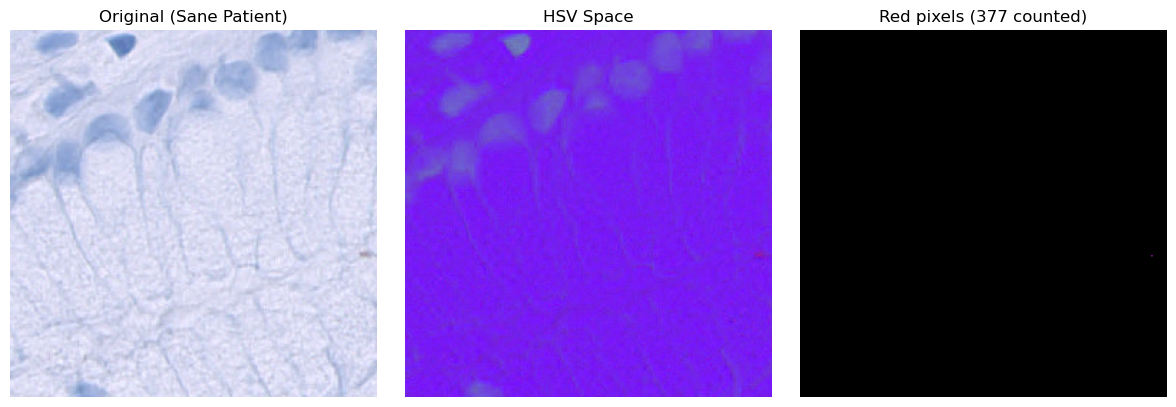

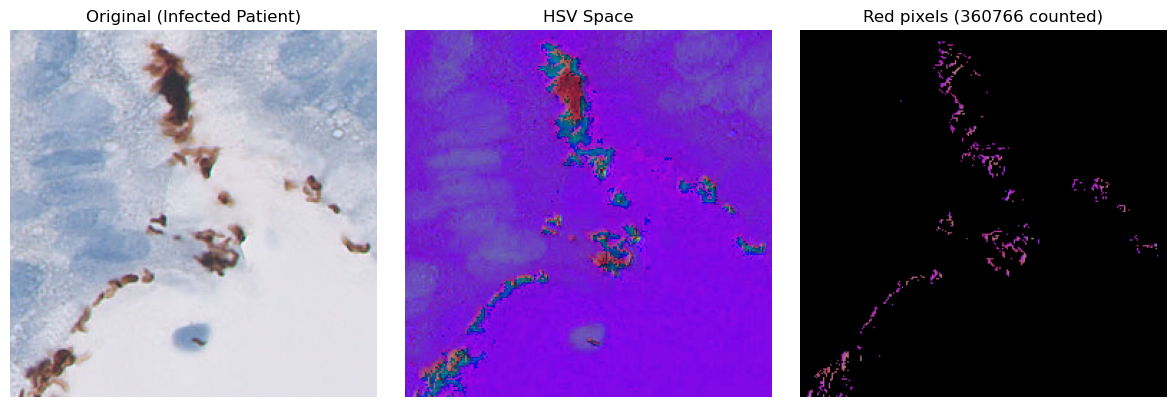

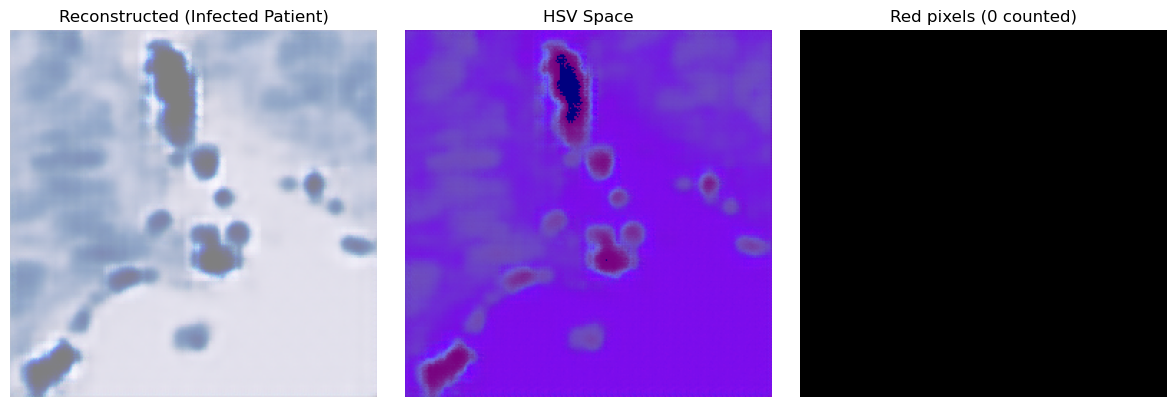

In [6]:
img_good = process_img(train_imgs[11]['img'][0], masking[0], masking[1])
img_bad = process_img(train_imgs[69]['img'][0], masking[0], masking[1])
img_bad_rec = process_img(train_imgs[69]['img'][1], masking[0], masking[1])

titles_good = ['Original (Sane Patient)', 'HSV Space', f'Red pixels ({img_good} counted)']
titles_bad = ['Original (Infected Patient)', 'HSV Space', f'Red pixels ({img_bad} counted)']
titles_bad_rec = ['Reconstructed (Infected Patient)', 'HSV Space', f'Red pixels ({img_bad_rec} counted)']

visualize(train_imgs[11]['img'][0], masking, titles_good)
visualize(train_imgs[69]['img'][0], masking, titles_bad)
visualize(train_imgs[69]['img'][1], masking, titles_bad_rec)

## Structure data

In [7]:
for element in train_imgs:
    if len(element['img']) > 1:
        element['features'] = element['info'][3:]    
        element['label'] = int(element['info'][2]) 
        element['info'] = element['info'][:2]   

for element in test_imgs:
    element['features'] = element['info'][2:]
    element['info'] = element['info'][:2]   

In [8]:
train_imgs[711]

{'img': [<PIL.Image.Image image mode=RGB size=256x256>,
  <PIL.Image.Image image mode=RGB size=256x256>],
 'info': ['B22-155', '3998_Aug3'],
 'features': [7024, 7024, 0.0001],
 'label': 1}

In [9]:
test_imgs[711]

{'img': [<PIL.Image.Image image mode=RGB size=256x256>,
  <PIL.Image.Image image mode=RGB size=256x256>],
 'info': ['B22-02', '307'],
 'features': [1513, 1513, 0.0007]}

In [20]:
# Load patients from pickle
with open('patients.pkl', 'rb') as f:
    patients = pickle.load(f)

In [ ]:
# Initialize each patient's dictionary independently to avoid shared references
temp1 = {key: {'label': -1, 'agg_npixel': 0, 'agg_diff': 0, 'prctg': [0, 0]} for key in patients[0]}
temp2 = {key: {'label': 1, 'agg_npixel': 0, 'agg_diff': 0, 'prctg': [0, 0]} for key in patients[1]}
patients = temp1 | temp2

In [22]:
for key in patients.keys():
    for element in train_imgs:
        if len(element['img']) > 1:
            if (key == element['info'][0]):
                    patients[key]['agg_npixel']+=element['features'][0]
                    patients[key]['agg_diff']+=element['features'][1]
                    patients[key]['prctg'][0]+=element['features'][2]
                    patients[key]['prctg'][1]+=1        
    
    for element in test_imgs:        
        if (key == element['info'][0]):
                patients[key]['agg_npixel']+=element['features'][0]
                patients[key]['agg_diff']+=element['features'][1]                
                patients[key]['prctg'][0]+=element['features'][2]
                patients[key]['prctg'][1]+=1

    if patients[key]['prctg'][1] > 0:
        patients[key]['mean_prctg'] = round(patients[key]['prctg'][0]/patients[key]['prctg'][1], 4)

In [24]:
# Rewrite pickle files
with open('train_imgs.pkl', 'wb') as f:
    pickle.dump(train_imgs, f)
with open('test_imgs.pkl', 'wb') as f:
    pickle.dump(test_imgs, f)
with open('patients.pkl', 'wb') as f:
    pickle.dump(patients, f)